In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import variation

# Changing rate of infection each year

##### PLAN

At end of each year - change beta eg $\beta \in \beta_0 [1,0.7, 0.5, 0.3]$

Run model multiple times and find variance for every time step

In [12]:
θ_new = np.load('../ABC/ABC_season/theta_new_F04_prior.npy')#ɛ>0
maxtol_new = len(θ_new)-1
dim_new = len(θ_new[0])
a_β, loc_β, scale_β = stats.gamma.fit(θ_new[maxtol_new][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ_new[maxtol_new][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ_new[maxtol_new][:,4]])

β = stats.gamma.rvs( a_β, loc_β, scale_β)
μ1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
μ2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
σ = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
ϵ = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)

random_E = np.random.randint(0,dim_new-1)
exposed = θ_new[maxtol_new][:,5][random_E]
birth = 1/(67*365)
μ = 1/(67*365)

In [450]:
def seasonalSEIR(initial, beta0,mu1, mu2, sigma, eps,mu, p, max_time):
    T = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    T.append(0)
    changes = [(365*i, 365*i+120) for i in range(int(round(max_time/365))+1)]
    changes = np.array(changes).flatten()
    t = 0
    ind = 0
    count = 0
    r = 0
    year = 1
    outbreaks = []
    times = []
    infectwithinoutbreak = []
    timewithinoutbreak = []
    infectwithinoutbreak.append(0)
    timewithinoutbreak.append(0)
    total_years = []
    event_years = []
    while t <max_time:
        betat = beta0
        if (math.ceil(t/365)) > year:
            total_years.append(sum(k==2 for k in event_years))
            outbreaks.append(infectwithinoutbreak)
            times.append(timewithinoutbreak)
            
            timewithinoutbreak = []
            infectwithinoutbreak = []
            infectwithinoutbreak.append(0)
            timewithinoutbreak.append(t)
            event_years = []
            year += 1
        if count<(len(changes)-2):
            if count%2 ==0:
                if changes[count+1]>= t >= changes[count]:
                    epsilon = eps*(1-p*(year-1))

                else:
                    count +=1 
                    T = T[:-1]
                    t = changes[count]
                    T.append(t)
            if count%2 ==1:
                if changes[count+1]>=t>=changes[count]:
                    epsilon = 0
                else:
                    count +=1 
                    T = T[:-1]
                    t= changes[count]
                    T.append(t)
                
        state = np.zeros(shape= (4,8))
        Rse = betat*(pop[ind][0])*(pop[ind][2])/N
        state[:,0] = [-1, 1, 0,0]
        
        Rse1 = epsilon*(pop[ind][0])
        state[:,1] = [-1,1,0,0]
        
        Rei = sigma*(pop[ind][1])
        state[:,2] = [0,-1,1,0]
        
        Rir = mu2*(pop[ind][2])
        state[:,3] = [0,0, -1,1]
        
        Ris = mu1*(pop[ind][2])
        state[:,4] = [1, 0,-1,0]
        
        Rid = mu*(pop[ind][2])
        state[:,5] = [1,0, -1, 0]
        
        Red = mu*(pop[ind][1])
        state[:,6] = [1,-1,0,0]
        
        Rsb = mu*(pop[ind][3])
        state[:,7] = [1, 0, 0, -1]
        
        rate = [Rse, Rse1, Rei, Rir, Ris, Rid, Red, Rsb]
        Rtotal = sum(rate)
        if Rtotal >0:
            delta_t= -np.log(np.random.uniform(0,1))/Rtotal
            if (t+delta_t) <changes[count+2]:
                
                P = np.random.uniform(0,1)*Rtotal
                t =t+ delta_t
                event = np.min(np.where(P<=np.cumsum(rate)))
                T.append(t)
                event_years.append(event)
                pop.append(pop[ind]+state[:,event])
                infectwithinoutbreak.append((pop[ind]+state[:,event])[2])
                timewithinoutbreak.append(t)
            else:
                count +=1
                if count>len(changes)-1:
                    break
                t = changes[count]
                T.append(t)
                pop.append(pop[ind])

        else: 
            count +=1 
            if count>len(changes)-1:
                break
            t = changes[count]

            T.append(t)
            pop.append(pop[ind])
        ind=ind+1

    return T, np.array(pop), total_years, times, outbreaks

In [456]:
K = seasonalSEIR([1500, 0,0,0], β,μ1, μ2, σ, ϵ,μ, 1/500, 500*365)
# plt.plot(K[0], K[1][:,2])

# K[0]
# 500*365

182500

[8,
 10,
 10,
 12,
 16,
 5,
 0,
 9,
 2,
 3,
 2,
 3,
 8,
 7,
 4,
 0,
 6,
 7,
 0,
 4,
 3,
 5,
 1,
 9,
 0,
 4,
 0,
 5,
 7,
 6,
 3,
 1,
 2,
 7,
 4,
 12,
 3,
 1,
 6,
 4,
 9,
 0,
 10,
 14,
 5,
 18,
 17,
 3,
 21,
 0,
 9,
 2,
 4,
 5,
 0,
 3,
 5,
 10,
 0,
 9,
 5,
 8,
 4,
 6,
 3,
 5,
 5,
 1,
 1,
 3,
 17,
 7,
 0,
 4,
 5,
 0,
 13,
 0,
 5,
 6,
 0,
 2,
 10,
 0,
 2,
 0,
 2,
 4,
 5,
 10,
 0,
 4,
 4,
 1,
 2,
 9,
 3,
 13,
 3,
 4,
 15,
 8,
 2,
 5,
 5,
 11,
 4,
 21,
 6,
 4,
 3,
 7,
 1,
 8,
 2,
 1,
 2,
 0,
 0,
 4,
 3,
 2,
 0,
 4,
 4,
 6,
 2,
 9,
 6,
 0,
 10,
 6,
 3,
 3,
 1,
 5,
 14,
 0,
 0,
 0,
 3,
 4,
 0,
 7,
 2,
 2,
 10,
 2,
 7,
 0,
 1,
 10,
 5,
 2,
 2,
 0,
 0,
 2,
 4,
 10,
 0,
 5,
 11,
 2,
 6,
 0,
 1,
 10,
 0,
 7,
 7,
 3,
 2,
 3,
 4,
 1,
 0,
 3,
 7,
 1,
 4,
 3,
 13,
 12,
 8,
 12,
 0,
 1,
 0,
 0,
 4,
 6,
 2,
 5,
 0,
 3,
 2,
 2,
 15,
 4,
 0,
 1,
 10,
 4,
 0,
 5,
 3,
 7,
 7,
 1,
 1,
 1,
 5,
 1,
 2,
 0,
 0,
 10,
 0,
 1,
 5,
 3,
 8,
 5,
 4,
 0,
 24,
 2,
 5,
 1,
 8,
 5,
 0,
 0,
 8,
 2,
 0,
 0,
 2,
 1,
 6,
 13

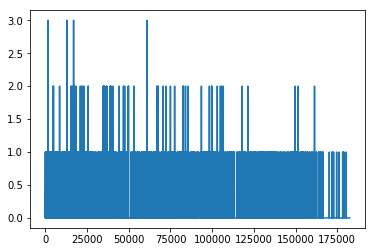

In [455]:
plt.plot(K[0], K[1][:,2])
K[2]

In [493]:
sim = 500
Y = 500
p = 1/Y
variance = np.zeros(shape = (sim, Y-1))
coefv = np.zeros(shape = (sim, Y-1))
mean = np.zeros(shape = (sim, Y-1))
for j in range(sim):
    print(j)
    simulation = np.zeros(shape = (Y-1, 365))
    for r in range(Y-1):
        time  = K[3][r]
        inf = K[4][r]

        inter_t = np.arange(365*r, 365*(r+1), 1) #interpolate to daily steps
    #     print(steps(time, inf)[0])
    #         print(len(inter_t))
        inter_inf = np.interp(inter_t, steps(time, inf)[0],steps(time, inf)[1])
    #     print(inter_inf)
        simulation[r,:] = inter_inf
    variance[j,:] = np.var(simulation/N, axis = 1)
    print(variation(simulation/N, axis = 1))
    coefv[j,:] =  variation(simulation/N, axis = 1)
    mean[j,:] = np.mean(simulation/N, axis = 1)

0
[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.6801

/home/emma/.local/lib/python3.5/site-packages/scipy/stats/stats.py:998: RuntimeWarning: invalid value encountered in true_divide
  return a.std(axis) / a.mean(axis)


[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

143
[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.68

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

294
[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.68

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

[ 5.20354908  4.064973    5.95818764  8.95048105  3.93391592 10.98483804
  8.48528137 10.98483804  5.95818764 19.07878403  5.20354908  7.73520092
 19.07878403  8.48528137 13.47219359  8.95048105         nan 10.98483804
  9.5        19.07878403 10.98483804  6.68019461  7.15142343 10.98483804
         nan  9.5         6.68019461 13.47219359  9.5                nan
         nan  4.67038542  6.28932075  6.28932075  7.15142343 19.07878403
 10.05982107         nan         nan         nan 19.07878403 10.98483804
  8.12655009 10.98483804  9.5                nan 13.47219359         nan
  6.68019461  4.83045892 10.98483804 13.47219359  8.12655009 13.47219359
  9.5        13.47219359 13.47219359  6.28932075  5.42371337 10.98483804
 10.98483804         nan 13.47219359 13.47219359  5.95818764         nan
         nan  9.5                nan 10.98483804 14.2048505   9.5
  8.48528137         nan         nan 10.98483804         nan  3.39614766
 13.47219359 13.47219359  7.15142343 13.47219359  6.680194

In [486]:
def integrand(x, a0,a1,a2, deta, ta, tc):
    return (a0 +a1*(x**2) + a2*(x**4))/((deta-(x**2)*ta)**2 + (x**2)*((tc+(x**2))**2))
from scipy.integrate import quad

In [497]:
np.nanmean(coefv[:,2])

5.958187643906493

In [488]:
quasi = []
quasi2 = []
quasi_cov = []
Q = []
m = []
N = 1500
for k in range(Y):
    b = β
    eps = ϵ*(1-p*k)
#     print(eps)
    #####fixed points #####

    [star0, star1, star2] = Qc(b, eps)

    m.append(star2)
    ##### matrices A and B ######
    A= np.matrix([[-b*star2-eps - μ, 0, μ1 - b*star0], 
                  [b*star2 + eps, -μ-σ*star1, b*star0], 
                  [0, σ*star1, -μ-μ1-μ2]])
    B = np.matrix([[b*star2*star0 + eps*star0+μ*(1-star0) + μ1*star2, -(b*star0*star2 +eps*star0+μ*star1), -(μ +μ1)*star2]
                   ,[-(b*star0*star2 +eps*star0+μ*star1), b*star0*star2+μ*star1+eps*star0+σ*star1, -σ*star1],
                  [-(μ+μ1)*star2, σ*star1, star2*(μ+μ1+μ2)+σ*star1]])
    det = np.linalg.det(A)
    C= np.linalg.inv(A)*(det*np.identity(3))
    alpha0 = (B[0,0]*(C[2,0]**2)+B[1,1]*(C[2,1]**2) + B[2,2]*(C[2,2]**2)+
            2*(C[2,0]*C[2,1]*B[0,1] + C[2,0]*C[2,2]*B[0,2] + C[2,1]*C[2,2]*B[1,2]))
    alpha1 = ((A[2,0]**2)*B[0,0] + 2*A[2,0]*A[2,1]*B[0,1] - 2*(C[2,0] + (A[0,0]+A[1,1])*A[2,0])*B[0,2] +
             (A[2,1]**2)*B[1,1] - 2*(C[2,1] +A[2,1]*(A[0,0] + A[1,1]))*B[1,2] +
             ((A[0,0] + A[1,1])**2 -2*C[2,2])*B[2,2])
    alpha2 = B[2,2]
    tra = np.trace(A)
    trc = np.trace(C)
    ######### Integration #########
    S = (1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[0]
    quasi.append(S/N)
    quasi_cov.append(np.sqrt(S/N)/star2)


In [489]:
def Qc(Bb, Ee):
    if Ee == 0:
        print('here')

        s =1
        i = 0
        e =0
        
    else:
        A = -(Bb/σ)*(σ+μ)*(μ+μ1+μ2)+μ1*Bb
        B = (Ee*μ1+μ*Bb - (σ + μ)*(μ+μ1+μ2)*((μ+Ee)/σ))
        C = μ*Ee
        if (-B-np.sqrt(B**2 - 4*A*C))/(2*A) >=0:
            i = (-B-np.sqrt(B**2 - 4*A*C))/(2*A)
        if (-B+np.sqrt(B**2 - 4*A*C))/(2*A) >= 0:
            i = (-B+np.sqrt(B**2 - 4*A*C))/(2*A)

        s = (((σ+μ)/σ)*(μ1+μ2+μ)*i)/(Bb*i + Ee)
        e = (i/σ)*(μ1 + μ2 + μ)
    
    return [s, e, i]

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


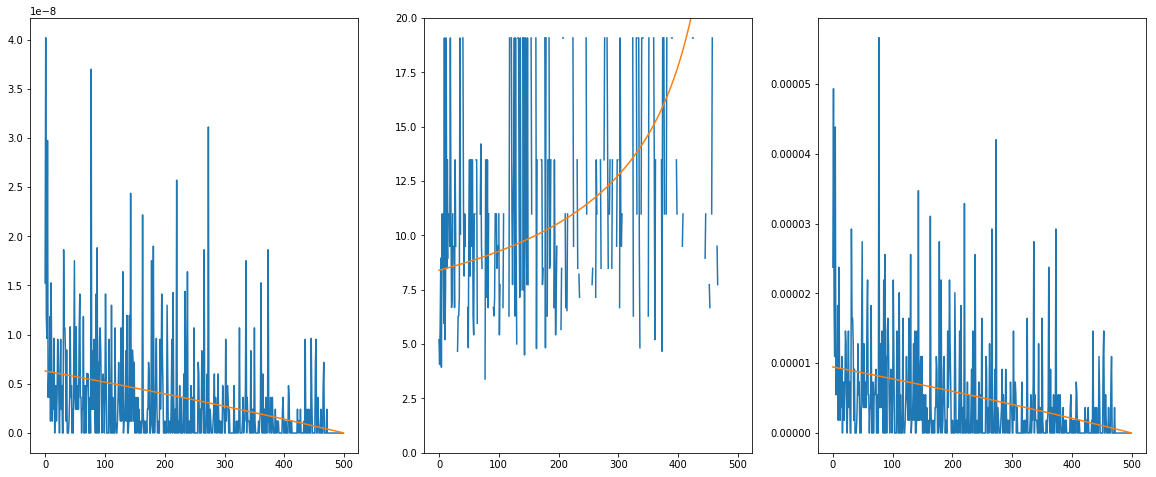

In [502]:
plt.figure(figsize = (20,8))
plt.subplot(1,3,1)
plt.plot(range(Y-1), np.mean(variance, axis = 0))
plt.plot(range(Y), quasi)
plt.subplot(1,3,2)
plt.plot(range(Y-1),np.nanmean(coefv, axis = 0))
plt.plot(range(Y), quasi_cov)
plt.ylim([0,20])
plt.subplot(1,3,3)
plt.plot(range(Y-1),np.mean(mean, axis = 0))
plt.plot(range(Y), m)

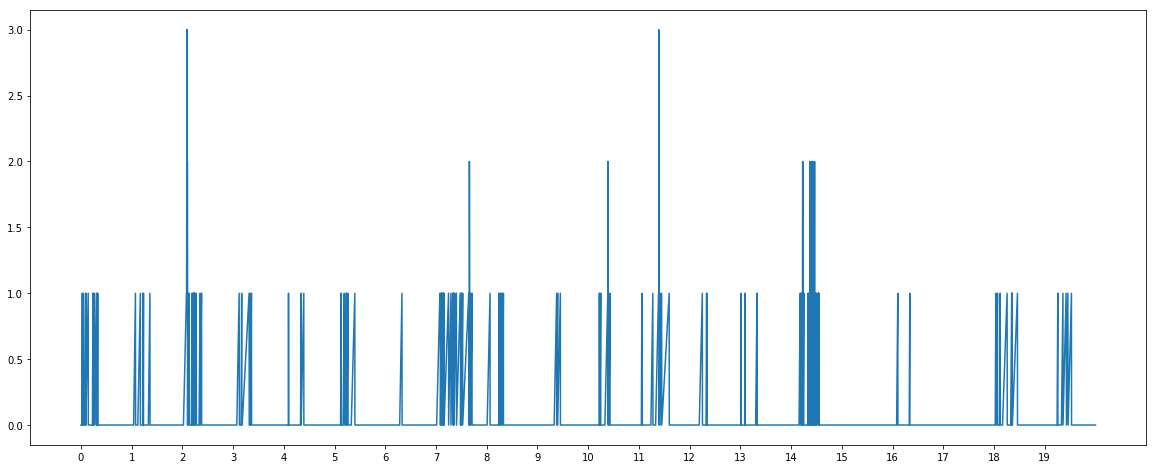

In [403]:
plt.figure(figsize = (20,8))
plt.plot(K[0], K[1][:,2])
plt.xticks([365*i for i in range(20)], range(20));
# plt.xlim()

In [501]:
quasi = []
quasi2 = []
quasi_cov = []
Q = []
m = []
N = 1500
for k in range(Y):
#     b = β*(1-p*k)
#     b = β*(1-p*k)
    b = β


    eps = (120*ϵ*(1-p*k)/365)
#             eps = 0
    [star0, star1, star2] = Qc(b, eps)
    mean_year.append(star2)
    A= np.matrix([[-b*star2-eps - μ, 0, μ1 - b*star0], 
              [b*star2 + eps, -μ-σ*star1, b*star0], 
              [0, σ*star1, -μ-μ1-μ2]])
    B = np.matrix([[b*star2*star0 + eps*star0+μ*(1-star0) + μ1*star2, -(b*star0*star2 +eps*star0+μ*star1), -(μ +μ1)*star2]
                   ,[-(b*star0*star2 +eps*star0+μ*star1), b*star0*star2+μ*star1+eps*star0+σ*star1, -σ*star1],
                  [-(μ+μ1)*star2, σ*star1, star2*(μ+μ1+μ2)+σ*star1]])
    det = np.linalg.det(A)
    C= np.linalg.inv(A)*(det*np.identity(3))
#     alph = (A[1,0]**2)*B[0,0] -2*A[0,0]*A[1,0]*B[1,0] +(A[0,0]**2)*B[1,1]
    alpha0 = (B[0,0]*(C[2,0]**2)+B[1,1]*(C[2,1]**2) + B[2,2]*(C[2,2]**2)+
            2*(C[2,0]*C[2,1]*B[0,1] + C[2,0]*C[2,2]*B[0,2] + C[2,1]*C[2,2]*B[1,2]))
    alpha1 = ((A[2,0]**2)*B[0,0] + 2*A[2,0]*A[2,1]*B[0,1] - 2*(C[2,0] + (A[0,0]+A[1,1])*A[2,0])*B[0,2] +
             (A[2,1]**2)*B[1,1] - 2*(C[2,1] +A[2,1]*(A[0,0] + A[1,1]))*B[1,2] +
             ((A[0,0] + A[1,1])**2 -2*C[2,2])*B[2,2])
    alpha2 = B[2,2]
#     det = np.linalg.det(A)
    tra = np.trace(A)
    trc = np.trace(C)
    ######### Integration #########
#     print(star0)
    S = (1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[0]
#     print((1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[1])
    quasi.append(S/N)
    quasi_cov.append(np.sqrt(S/N)/star2)
    m.append(star2)
    
#     #####fixed points #####

#     [star0, star1, star2] = Qc(b, eps)
#     print(star2*10)
#     star2 = star2*10
#     m.append(star2)
#     ##### matrices A and B ######
#     A= np.matrix([[-b*star2-eps - μ, 0, μ1 - b*star0], 
#                   [b*star2 + eps, -μ-σ*star1, b*star0], 
#                   [0, σ*star1, -μ-μ1-μ2]])
#     B = np.matrix([[b*star2*star0 + eps*star0+μ*(1-star0) + μ1*star2, -(b*star0*star2 +eps*star0+μ*star1), -(μ +μ1)*star2]
#                    ,[-(b*star0*star2 +eps*star0+μ*star1), b*star0*star2+μ*star1+eps*star0+σ*star1, -σ*star1],
#                   [-(μ+μ1)*star2, σ*star1, star2*(μ+μ1+μ2)+σ*star1]])
#     det = np.linalg.det(A)
#     C= np.linalg.inv(A)*(det*np.identity(3))
# #     alph = (A[1,0]**2)*B[0,0] -2*A[0,0]*A[1,0]*B[1,0] +(A[0,0]**2)*B[1,1]
#     alpha0 = (B[0,0]*(C[2,0]**2)+B[1,1]*(C[2,1]**2) + B[2,2]*(C[2,2]**2)+
#             2*(C[2,0]*C[2,1]*B[0,1] + C[2,0]*C[2,2]*B[0,2] + C[2,1]*C[2,2]*B[1,2]))
#     alpha1 = ((A[2,0]**2)*B[0,0] + 2*A[2,0]*A[2,1]*B[0,1] - 2*(C[2,0] + (A[0,0]+A[1,1])*A[2,0])*B[0,2] +
#              (A[2,1]**2)*B[1,1] - 2*(C[2,1] +A[2,1]*(A[0,0] + A[1,1]))*B[1,2] +
#              ((A[0,0] + A[1,1])**2 -2*C[2,2])*B[2,2])
#     alpha2 = B[2,2]
# #     det = np.linalg.det(A)
#     tra = np.trace(A)
#     trc = np.trace(C)
#     ######### Integration #########
# #     print(star0)
#     S = (1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[0]
# #     print((1/(2*np.pi))*quad(integrand, -np.inf, np.inf, args=(alpha0, alpha1, alpha2, det, tra, trc))[1])
#     quasi.append(S/N)
#     quasi_cov.append(np.sqrt(S/N)/star2)